In [13]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt




In [14]:
#Define paths
currentDir = os.getcwd()
accelerometerDataPath = os.path.join(currentDir, "data", "all_accelerometer_data_pids_13.csv")
tacDataPath = os.path.join(currentDir, "data", "clean_tac")
phoneTypesPath = os.path.join(currentDir, "data", "phone_types.csv")

In [15]:
#Combine clean_tac into one dataframe
csvFiles = glob.glob(os.path.join(tacDataPath, '*.csv'))
print(csvFiles)
tacDataFrames = []

for csvFile in csvFiles:
    tacDataFrames.append(pd.read_csv(csvFile))

['c:\\Users\\mrcat\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\BK7610_clean_TAC.csv', 'c:\\Users\\mrcat\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\BU4707_clean_TAC.csv', 'c:\\Users\\mrcat\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\CC6740_clean_TAC.csv', 'c:\\Users\\mrcat\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\DC6359_clean_TAC.csv', 'c:\\Users\\mrcat\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\DK3500_clean_TAC.csv', 'c:\\Users\\mrcat\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\HV0618_clean_TAC.csv', 'c:\\Users\\mrcat\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\JB3156_clean_TAC.csv', 'c:\\Users\\mrcat\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\JR8022_clean_TAC.csv', 'c:\\Users\\mrcat\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\MC7070_clean_TAC.csv', 'c:\\Users\\mrcat\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\MJ8002_clean_TAC.csv', 'c:\\Users\\mrcat\\

In [16]:
#Loading data files

tacData = pd.concat(tacDataFrames, ignore_index=True)
accelerometerData = pd.read_csv(accelerometerDataPath)
phoneTypes = pd.read_csv(phoneTypesPath)

In [17]:
#Check dataframes
tacData.head()
accelerometerData.head()
phoneTypes.head()


,pid,phonetype
0,BK7610,iPhone
1,BU4707,iPhone
2,CC6740,Android
3,DC6359,iPhone
4,DK3500,iPhone


In [18]:
#Check for null
tacData.isnull().sum()
accelerometerData.isnull().sum()
phoneTypes.isnull().sum()

pid          0
phonetype    0
dtype: int64

In [19]:
#Connect accelerometer data with their respective phone types
accelerometerData = accelerometerData.merge(phoneTypes, on='pid')

In [20]:
#Identify bar crawl events (increased movement)
movementThreshold = .5
segmentLength = 60
barCrawlEvents = []


In [21]:
#Iterate through participants data
for participant_id, participant_data in accelerometerData.groupby('pid'):
    participant_data['magnitude'] = (participant_data['x']**2 + participant_data['y']**2 + participant_data['z']**2)**.2

    numSegments = len(participant_data) // segmentLength
    for i in range(numSegments):
        segmentStart = i * segmentLength
        segmentEnd = (i + 1) * segmentLength
        segmentData = participant_data.iloc[segmentStart:segmentEnd]

        if segmentData['magnitude'].max() > movementThreshold:
            barCrawlEvents.append({ 
                'participant_id': participant_id,
                'segment_start_time': segmentData['time'].iloc[0],
                'segment_end_time': segmentData['time'].iloc[-1],
                'magnitude': segmentData['magnitude'].max()
            })

barCrawlEventsDf = pd.DataFrame(barCrawlEvents)

In [22]:
#Define heavy drinking episodes based on the TAC threshold (united states legislation threshold 0.08)
tacThreshold = 0.08
heavyDrinkingEpisodes = tacData[tacData['TAC_Reading'] >= tacThreshold]

mergeData = pd.merge_asof(barCrawlEventsDf.sort_values('segment_start_time'), 
                          tacData.sort_values('timestamp'), 
                          left_on='segment_start_time', 
                          right_on='timestamp', 
                          tolerance=60000)
correlation = mergeData['magnitude'].corr(mergeData['TAC_Reading'])
print(barCrawlEventsDf)
print("Correlation between bar crawls and heavy drinking episodes: ", correlation)

       participant_id  segment_start_time  segment_end_time  magnitude
0              BK7610       1493735870653     1493735872129   0.567631
1              BK7610       1493735873655     1493735875134   0.619921
2              BK7610       1493735875156     1493735876632   0.508015
3              BK7610       1493735885661     1493735887137   0.588549
4              BK7610       1493735888663     1493735890139   0.614804
...               ...                 ...               ...        ...
100797         SF3079       1493782329150     1493782330628   0.623621
100798         SF3079       1493782330664     1493790814367   1.002390
100799         SF3079       1493790814369     1493790814860   1.163447
100800         SF3079       1493790814863     1493790815950   1.017784
100801         SF3079       1493790823484     1493790824943   1.081954

[100802 rows x 4 columns]
Correlation between bar crawls and heavy drinking episodes:  nan


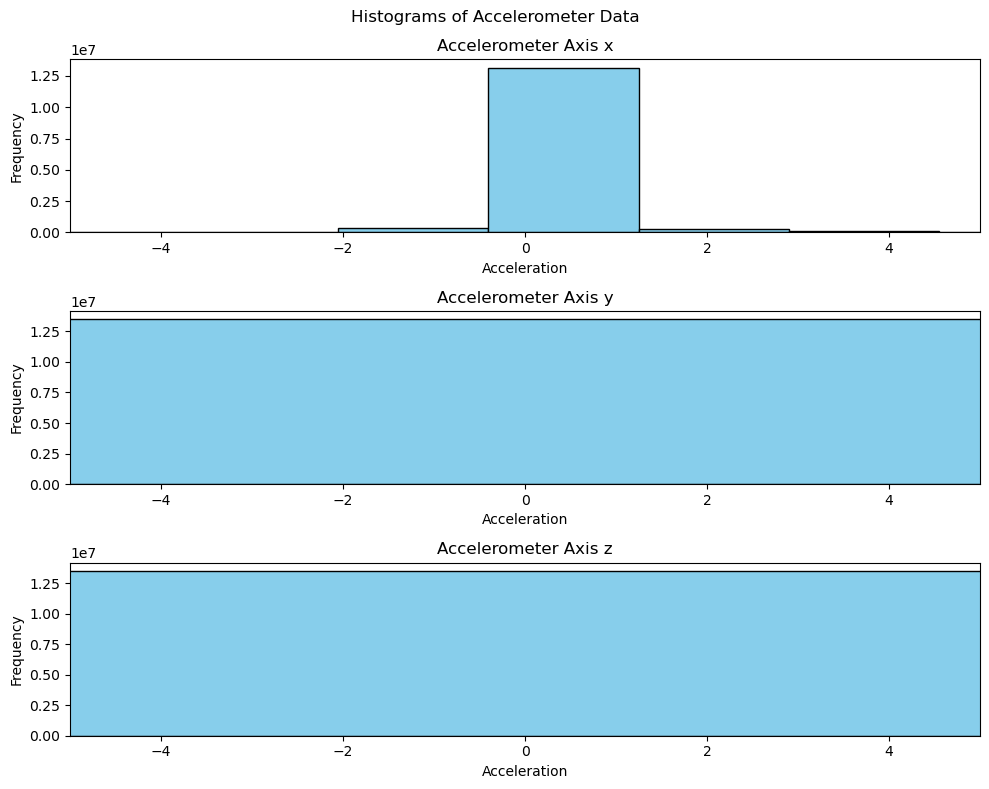

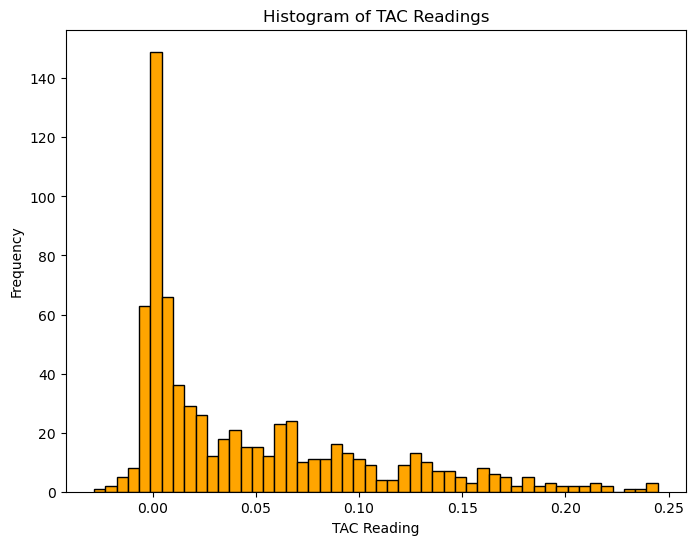

In [23]:
#Set up the figure
fig, axs = plt.subplots(3, 1, figsize=(10, 8))
fig.suptitle('Histograms of Accelerometer Data')

#Plot histograms
for i, axis in enumerate(['x', 'y', 'z']):
    axs[i].hist(accelerometerData[axis], bins=50, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Accelerometer Axis {axis}')
    axs[i].set_xlabel('Acceleration')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlim(-5, 5)

plt.tight_layout()
plt.show()

#TAC histogram
plt.figure(figsize=(8, 6))
plt.hist(tacData['TAC_Reading'], bins=50, color='orange', edgecolor='black')
plt.title('Histogram of TAC Readings')
plt.xlabel('TAC Reading')
plt.ylabel('Frequency')
plt.show()

In [24]:
#EDA
print(mergeData.columns)
X = mergeData[['magnitude', 'TAC_Reading']]
y = mergeData['heavy_drinking_episode']

print(mergeData['heavy_drinking_episode'])

print(X)
print(y)

Index(['participant_id', 'segment_start_time', 'segment_end_time', 'magnitude',
       'timestamp', 'TAC_Reading'],
      dtype='object')


KeyError: 'heavy_drinking_episode'

In [ ]:
#Handle any NA 
#X = X.fillna(X.mean())

In [ ]:
#Train-test split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print("Baseline: ", acc)

(0, 2)
(20161, 2)
(80641, 3)
(20161, 3)


ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by RandomForestClassifier.

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.